#  Data Exploration Global $ CO_2 $
Aquiring reliable data, is the foundation for any analysis project. If your data is incomplete inaccurate, any analysis will draw poor conclusions. 

After aqusition data which has been well formatted into a csv, or similar easy to handle file, should be explored. 

In [2]:
from dur_utils import colours #Durham Utilities module that stores constants like colours, can be found on _githublink_
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize 

Handling imports is typically done at the top of the file. The best practice is to avoid having redundant imports in a file. Avoiding double imports and redundant imports reduces the possibility of incompatibility errors.
The first section will collect data from the [NOAA/GML](https://gml.noaa.gov/ccgg/trends/gl_data.html){cite}`Tans1995,Conway1994`. There are multiple files on the website; [mean monthly csv](https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv) was chosen. CSV or comma-separated variable files are a common way of storing tabular data. [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) and [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) both have functions which read CSVs. Pandas is much faster. 
```
pd.read_csv(file)
```
```
np.loadtxt(file, delimiter = ',')
```

In [3]:
path_global = 'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_gl.csv'
co2_data_global = pd.read_csv(
    path_global, header=0, comment='#'
    )
null_sum = (co2_data_global.isna()).values.sum(axis=0)
pd.DataFrame(data=null_sum,
    index=co2_data_global.columns,
    columns=['Number of Null Values']
    )

,Number of Null Values
year,0
month,0
decimal,0
average,0
trend,0


Tabulating the number of null entries in each column provides a reference to column names and the number of missing entries. In this data, there are no Null fields.
Notably, none of the columns has units in their headers apart from years and months. On inspection of the website, the average column is a pseudo-unit quantity in parts per million. 

If there were large counts of null entries, a decision on whether to use the current dataset should be made. The effect of missing data has entire fields of research dedicated to it. There are multiple different statistical methods available to repopulate your datasets. This, however, is beyond the remit of this text.  

When Displaying the ``` co2_data_global``` dataframe up to the first five rows, it can be seen that the decimal column is given by: 
\begin{equation}
decimal = year + \frac{month}{12}
\end{equation}
This makes it straightforward to plot $CO_2$ average against time.  

In [4]:
co2_data_global.iloc[:5,:]

,year,month,decimal,average,trend
0,1980,1,1980.042,338.55,337.93
1,1980,2,1980.125,339.27,338.22
2,1980,3,1980.208,339.60,338.25
3,1980,4,1980.292,339.99,338.37
4,1980,5,1980.375,340.43,338.91


By plotting the monthly average against time and the trendline provided shows a consistent increase in the average concentration of $CO_2$ in the atmosphere over the last 40 years. In addition, a cyclical pattern over a shorter timescale is also observed. Therefore, drawing conclusions from the data is possible. 

There is an additional data set from Mauna Loa {cite}`Tans1989`, which is worth comparing to global averages. Notably, these data sets are not expected to correspond precisely as $CO_2$ concentration is a function of altitude, latitude and longitude. 

In this case, we know that the surface average $CO_2$ is taken from multiple sea-level sites. Each site is part of the Cooperative Global Air Sampling Network{cite}`. These sites have been chosen to minimise the interference of local effects in the amount of atmospheric $CO_2$. 

There can be no hard and fast rule for how many data sources are required to make predictions. However, with more independent sets of data, confidence in the generality of predictions can increase. Further, both of these datasets come from peer-reviewed sources. Thus their methodology has been independantly certified.   

 

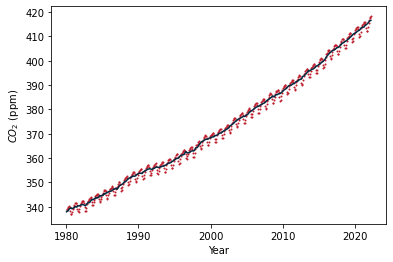

In [5]:
plt.plot(co2_data_global['decimal'], co2_data_global['average'],
        c=colours.durham.red, linestyle='',
        marker='o', markersize = 1
        )
plt.plot(co2_data_global['decimal'], co2_data_global['trend'],
        c=colours.durham.ink
        )
plt.ylabel('$CO_2$ (ppm)')
plt.xlabel('Year')
None

In [6]:
path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
null_sum = (co2_data_ml.isna()).values.sum(axis=0)
pd.DataFrame(data=null_sum,
    index=co2_data_ml.columns,
    columns=['Number of Null Values']
    )

,Number of Null Values
year,0
month,0
day,0
decimal,0
average,0
ndays,0
1 year ago,0
10 years ago,0
increase since 1800,0


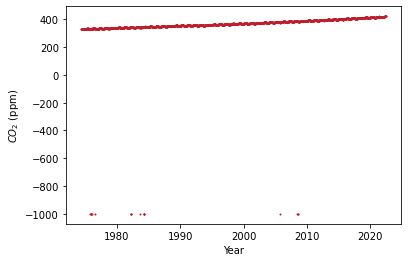

In [7]:
plt.plot(co2_data_ml['decimal'], co2_data_ml['average'],
        c = colours.durham.red, linestyle='',
        marker='o', markersize = 1
        )
plt.ylabel('$CO_2$ (ppm)')
plt.xlabel('Year')
None

In [8]:
invalid_values = np.sum(co2_data_ml['average']<0)
iv_fraction = invalid_values / co2_data_ml.shape[0]
print(' Number of discarded data points:', invalid_values,
    ', Fraction of Total Values:', f'{iv_fraction:.2}'
    )


 Number of discarded data points: 18 , Fraction of Total Values: 0.0072


The weekly Mauna Loa data contains more fields than the global average data. However, the decimal format is still available. In this dataset, there are clear anomalous data points. -1000 is a non-physical concentration, so cleaning the rows that lack data for these weeks is essential before further processing. Significantly, less than one percent of the values are null, and no effort is made to replace them.    

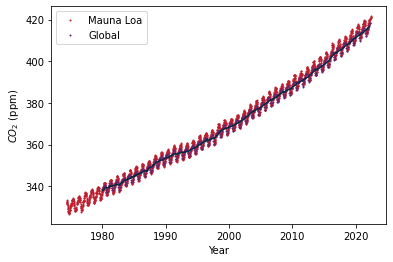

In [9]:
co2_data_ml = co2_data_ml[co2_data_ml['average']>0] 
#Plotting
plt.plot(co2_data_ml['decimal'], co2_data_ml['average'],
        c = colours.durham.red, linestyle='',
        marker='o', markersize = 1, 
        label = 'Mauna Loa'
        )
plt.plot(co2_data_global['decimal'], co2_data_global['average'], 
        c=colours.durham.purple, linestyle='', marker='o', markersize = 1, label = 'Global'
        )
plt.plot(co2_data_global['decimal'], co2_data_global['trend'], 
        c=colours.durham.ink
        ) 
plt.ylabel('$CO_2$ (ppm)')
plt.xlabel('Year')
plt.legend()
None

## Fitting 
When performing curve fitting, the method of non-linear least-squares fitting is typically appropriate. The principle behind least-squares fitting is reducing the residual between the data and the fit. The N point residual for a scalar function, 
```{math}
:label: Residuals
r = \sum_{i = 0}^N(y'(\vec{x_i},\vec{p})-y(\vec{x_i}))^2.
``` 
Where  $y'(\vec{x},\vec{p})$  is the model function and  ${math}y(\vec{x})$  the data. 

For a scalar function, the fitted line  $ y'(x,\vec{p})$  is a function of the data and the free parameters of the curve $ \vec{p} \in \mathbb{R}^m $. An iterative solution to minimise the residuals can be found for any non-linear problem. For the linear subclass of problems, an analytic solution to a set of equations can be found. Each residual in equation {eq}`Residuals`, can be considered as its own function $ r_i(\vec{p})$. The Jacobian matrix's pseudo inverse {eq}`Pseudo` corresponds to the direction each vector must change and the curvature of the error surface. The minimisation can be considered as a ball rolling down an error surface in steps. The step size is proportional to both the gradient and the curvature of the slope. A full treatment of this can be found in chapter 7 of 'Measurements and Their Uncertainties'{cite}`Hughs_Hase`. 

```{math}
(J_r)_{ij} = \frac{\partial r_i}{\partial p_j}
```

```{math}
:label: Pseudo
\Delta  = - (J_r^TJ_r)^{-1}J_r^Tr(\vec{p})
``` 

```{math}
\vec{p}_{t+1} = \Delta \vec{p} + \vec{p}_t
```
```{note}
The method described breifly here is the Gauss Newton algorithm, which is not used in practice. There are alternative implementations of minimising the least squarest problem depending on a multitude of factors, particularly bounds. Scipy itself uses multiple algorithms, described [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq).  
```

### Applying Curve Fitting to $CO_2$ Data
In order to make predictions from the current data, performing a functional fit to the data and using this to extrapolate into the future is the most elementary predictive step we can take. The model takes historical training data and adjusts its parameters $\vec{p}$ to emulate the data best. The most elementary version of this is a constant. 

```{math}
y' = c
```

Intuitively one would draw a line to fit this data, a model with two free parameters. A polynomial fit is the higher freedom extension to this. Increased dimensions in $\vec{p}$ will reduce the size of residuals. An exact fit can be found by increasing the order of the polynomial. However, this comes at a cost to the generalisability of the model. For example 



In [17]:
def compound_mask(array: pd.DataFrame, *tuples):
    '''
    A function which takes the product of multiple masks

    Input :
    array: pd.DataFrame, with column keys that contain 
    *tuples: (column_key: string in array.keys(),
        values: list of items in array[column_key]
        )

    Output:
    pd.DataFrame, which satisfies all of the conditions 
    provided by the tuples
    '''
    mask = True
    for colum_name, values in tuples:
        cond = array[colum_name].isin(values)
        mask = mask & cond
    return array[mask]

# Define overfit polynomial
def p3(x, a_0, a_1, a_2, a_3):
    return a_0 + a_1*x + a_2*x**2 + a_3*x**3
# Define more reasonable poly 
def p1(x, a_0, a_1):
    return a_0 + a_1*x
# Define underfit poly
def p0(x, a_0,):
    return [a_0 for i in x] 
# Data For Fitting
fit_test = compound_mask(co2_data_global, 
    ('month',[6]),
    ('year',[1991,1992,1993,1994])
    )
fit_extension = compound_mask(co2_data_global, 
    ('month',[6]),
    ('year',[i for i in range(1985,2000)])
    )
# Fit Coefs
p0_fit, p0_error = scipy.optimize.curve_fit(p0,
    fit_test['decimal'],
    fit_test['average']
    )

p1_fit, p1_error = scipy.optimize.curve_fit(p1,
    fit_test['decimal'],
    fit_test['average']
    )

p3_fit, p3_error = scipy.optimize.curve_fit(p3,
    fit_test['decimal'],
    fit_test['average']
    )

/home/sean/anaconda3/envs/CDS_book/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


```{note}
There are quite a few interesting subtlties brought up by this example. 
- The P3 polynomial, does not exactly fit the datapoints on the left hand figure. This illustrates the iterative approximate solution provided by the ```scipy.optimise.curvefit``` function.
- The P3 polynomial fits the data quite well above 1991. It is clear however that the polynomial is overfitting when looking at time periods before 1991, as the trendline doen't characterise the behaviour well.
- P3 polynomial, is the highest order polynomial for which there is one exact solution that goes through all of the data points. For P4 and above there are an infinite set of polynomials that go through 4 points. 
```

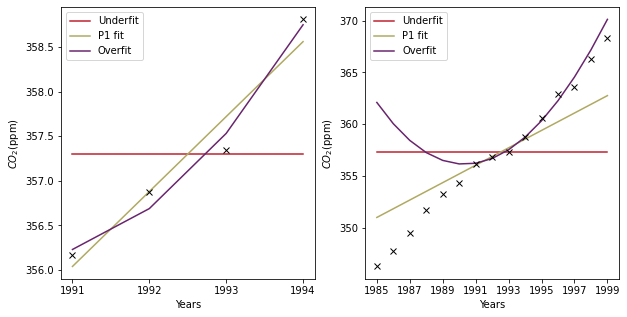

In [18]:

#Plotting
fig, ax = plt.subplots(1, 2, figsize = (10,5))
# First axis
ax[0].plot(fit_test['decimal'],
    p0(fit_test['decimal'], *p0_fit),
    label = 'Underfit',
    c = colours.durham.red
    )
ax[0].plot(fit_test['decimal'],
    p1(fit_test['decimal'], *p1_fit),
    label = 'P1 fit',
    c = colours.durham.green
    )
ax[0].plot(fit_test['decimal'],
    p3(fit_test['decimal'], *p3_fit),
    label = 'Overfit',
    c = colours.durham.purple
    )
ax[0].plot(fit_test['decimal'],
    fit_test['average'],
    linestyle = '',
    marker = 'x',
    c = 'black'
    )
ax[0].legend()
ax[0].set_xticks(fit_test['decimal'])
ax[0].set_xticklabels([i for i in range(1991,1995)])
ax[0].set_xlabel('Years')
ax[0].set_ylabel('$CO_2$(ppm)')
#Extended Axis
ax[1].plot(fit_extension['decimal'],
    p0(fit_extension['decimal'], *p0_fit),
    label = 'Underfit',
    c = colours.durham.red
    )
ax[1].plot(fit_extension['decimal'],
    p1(fit_extension['decimal'], *p1_fit),
    label = 'P1 fit',
    c = colours.durham.green
    )
ax[1].plot(fit_extension['decimal'],
    p3(fit_extension['decimal'], *p3_fit),
    label = 'Overfit',
    c = colours.durham.purple)
ax[1].plot(fit_extension['decimal'],
    fit_extension['average'],
    linestyle = '',
    marker = 'x',
    c = 'black'
    )
ax[1].legend()
ax[1].set_xticks(fit_extension['decimal'].iloc[::2])
ax[1].set_xticklabels([i for i in range(1985,2000,2)])
ax[1].set_xlabel('Years')
ax[1].set_ylabel('$CO_2$(ppm)')
None


Hypothesis testing and $\Chi^2$ statistics tests quantify the validity and 'goodness of fit', respectively. Again a thorough treatment of the $\Chi^2$ statistic is presented in chapters 5 and 8 of 'Measurements and Their Uncertainties'{cite}`Hughs_Hase`.  

# Plan
- Look for the impact of covid, on global CO_2, and explore what sort of line of best fit best matches the data. 
- look at the results from C0_2. Can we see a difference due to covid and the reduction in CO_2 production
- Excercise, do similar for methane. 